# HR 8799 GTO 1194 

This program will search for previously unknown planets using NIRCam in the F356W and F444W filters using the MASK430R for both filters.
In addition, we will probe the physical characterization of the known planets, HR8789bcde, using multi-filter photometry with the LW Bar mask. 
The medium-band filters will be observed with a fiducial override to place the primary source on the narrow end of the occulting mask.
The NIRCam observations will use two roll angles ($\pm$5 deg) and a reference star to assist with suppression of residuals in the coronagraphic image.

This notebook uses output from the APT file of PID 1194 to simulate the obsevations and save them to DMS-like FITS files (Level 1b data).

In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

# Progress bar
from tqdm.auto import trange, tqdm

In [2]:
import os

import pynrc
from pynrc import nrc_utils
from pynrc import nrc_utils, nircam_cal, DMS_input, DetectorOps
from pynrc.simul.apt import get_detname
# from pynrc.simul.ngNRC import create_level1b_FITS

pynrc.setup_logging('WARN', verbose=False)

## Source Definitions

We will utilize the `source_spectrum` class to generate a model fit to the known spectrophotometry. The user can find the relevant photometric data at http://vizier.u-strasbg.fr/vizier/sed/ and click download data as a VOTable.

In [3]:
# Define 2MASS Ks bandpass and source information
bp_k = pynrc.bp_2mass('k')

# Science    source,  dist, age, sptype, Teff, [Fe/H], log_g, mag, band
args_sci = ('HR 8799', 39.0, 30,  'F0V', 7430, -0.47, 4.35, 5.24, bp_k)

# References  source,     sptype, Teff, [Fe/H], log_g, mag, band
args_ref = ('HD 220657', 'F8III', 5888, -0.01, 3.22, 3.04, bp_k)

# Directory housing VOTables 
# http://vizier.u-strasbg.fr/vizier/sed/
votdir = 'GTO/votables/'

In [4]:
# Fit spectrum to SED photometry
name_sci, dist_sci, age, spt_sci, Teff_sci, feh_sci, logg_sci, mag_sci, bp_sci = args_sci
vot = votdir + name_sci.replace(' ' ,'') + '.vot'

args = (name_sci, spt_sci, mag_sci, bp_sci, vot)
kwargs = {'Teff':Teff_sci, 'metallicity':feh_sci, 'log_g':logg_sci}
src = pynrc.source_spectrum(*args, **kwargs)

src.fit_SED(use_err=False, robust=False, wlim=[1,5])

# Final source spectrum (pysynphot)
sp_sci = src.sp_model

[1.00382305]


In [5]:
# Do the same for the reference source
name_ref, spt_ref, Teff_ref, feh_ref, logg_ref, mag_ref, bp_ref = args_ref
vot = votdir + name_ref.replace(' ' ,'') + '.vot'

args = (name_ref, spt_ref, mag_ref, bp_ref, vot)
kwargs = {'Teff':Teff_ref, 'metallicity':feh_ref, 'log_g':logg_ref}
ref = pynrc.source_spectrum(*args, **kwargs)

ref.fit_SED(use_err=False, robust=False, wlim=[0.5,10])

# Final reference spectrum (pysynphot)
sp_ref = ref.sp_model

[1.09536204]


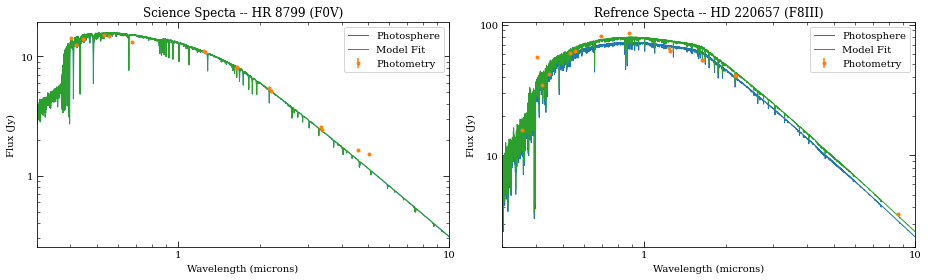

In [6]:
# Plot spectra 
fig, axes = plt.subplots(1,2, figsize=(13,4))
src.plot_SED(xr=[0.3,10], ax=axes[0])
ref.plot_SED(xr=[0.3,10], ax=axes[1])

axes[0].set_title('Science Specta -- {} ({})'.format(src.name, spt_sci))
axes[1].set_title('Refrence Specta -- {} ({})'.format(ref.name, spt_ref))

fig.tight_layout()

# Create Observation Parameters

These will used for input into the data ramp simulator and directly correspond to parameters for DMS FITS creation to ingest into the JWST pipeline

In [7]:
pid_str = 'pid1194'

save_dir = f'/data/NIRData/NRC_Sims/Sim_{pid_str}/'

# APT input files
apt_file_dir = 'APT_output/'
json_file     = f'{apt_file_dir}{pid_str}.timing.json'
sm_acct_file  = f'{apt_file_dir}{pid_str}.smart_accounting'
pointing_file = f'{apt_file_dir}{pid_str}.pointing'
xml_file      = f'{apt_file_dir}{pid_str}.xml'

In [8]:
loc_list = [(-1.625, 0.564), (0.319, 0.886), (0.588, -0.384), (0.249, 0.294)]

# Estimated magnitudes within F444W filter
pmags = [16.0, 15.0, 14.6, 14.7]

In [9]:
# Science and reference information
params_hci_src = {'sp_sci': sp_sci, 'sp_ref': sp_ref, 'dist_sci': dist_sci}

# Companions around science target
# See obs_hci.add_planets() for relevant keywords
bp_renorm = pynrc.read_filter('F430M')
params_hci_companions = {
    'b' : {'xy':(-1.625,  0.564), 'runits':'arcsec', 'renorm_args':(16.0, 'vegamag', bp_renorm)},
    'c' : {'xy':( 0.319,  0.886), 'runits':'arcsec', 'renorm_args':(15.0, 'vegamag', bp_renorm)},
    'd' : {'xy':( 0.588, -0.384), 'runits':'arcsec', 'renorm_args':(14.6, 'vegamag', bp_renorm)},
    'e' : {'xy':( 0.249,  0.294), 'runits':'arcsec', 'renorm_args':(14.7, 'vegamag', bp_renorm)},
}

# Disk model
params_disk_model = None

# params_disk_model = {
#     'file': '/Users/jarron/NIRCam/DebrisDisk_models_v2/HD10647/HD10647_F300Msc.fits',
#     'pixscale': 0.01575,
#     'dist': 17.34,
#     'wavelength': 3.0,
#     'units': 'Jy/pixel',
#     'cen_star': True,
#     'npsfs_per_axis': 9,
# }

src_tbl = None

In [10]:
pid_str = 'pid1194'

sim_config = {
    # APT input files
    'json_file'     : f'{pid_str}.timing.json',
    'sm_acct_file'  : f'{pid_str}.smart_accounting',
    'pointing_file' : f'{pid_str}.pointing',
    'xml_file'      : f'{pid_str}.xml',
    # Output directory
    'save_dir'      : f'/Users/jarron/NIRCam/Data/Sim_{pid_str}/',
    
    # Date and time of observations
    'obs_date' : '2022-11-03', 
    'obs_time' : '12:00:00',
    # Position angle of observatory
    # User should check acceptable range in APT's Roll Analysis
    'pa_v3'    : 90.0,
    
    # Source information
    'src_tbl' : src_tbl,  # source table with RA, Dec, and filter mags
    'params_hci_src'        : params_hci_src,
    'params_disk_model'     : params_disk_model,
    'params_hci_companions' : params_hci_companions,
    
    # PSF size information for WebbPSF_ext
    'params_webbpsf' : {'fov_pix': 257, 'oversample': 2},
    # Position-dependent PSFs for convolution
    'params_psfconv' : {'npsf_per_full_fov': 5, 'osamp': 1, 'sptype': 'G0V'},
    # Wavefront error drift settings
    'enable_wfedrift' : False,
    # For coronagraphic masks, sample large grid of points?
    'large_grid' : True,
    
    # Slew and dither pointing uncertainties
    'large_slew' : 100.0,   # Slew to target (mas)
    'ta_sam'     : 5.0,     # SAM movements from TA position (mas)
    'std_sam'    : 5.0,     # Standard dither values (mas)
    'sgd_sam'    : 2.5,     # Small grid dithers (mas)
    
    # Type of image files to save
    'save_slope' : False,  # Save ideal noiseless slope images to FITS
    'save_dms'   : True,   # Save DMS-like ramps to FITS
    'dry_run'    : False,  # Perform a dry-run, not generating any data, just printing visit info

    # Ramp parameters
    'params_noise' : {
        'include_dark'      : True,     # Dark current
        'include_bias'      : True,     # Bias image offset
        'include_ktc'       : True,     # kTC Noise
        'include_rn'        : True,     # Read Noise
        'include_cpink'     : True,     # Correlated 1/f noise between channel
        'include_upink'     : True,     # Channel-dependent 1/f noise
        'include_acn'       : True,     # Alternating column noise
        'apply_ipc'         : True,     # Interpixel capacitance
        'apply_ppc'         : True,     # Post-pixel coupling
        'amp_crosstalk'     : True,     # Amplifier crosstalk
        'include_refoffsets': True,     # Reference offsets
        'include_refinst'   : True,     # Reference pixel instabilities
        'include_colnoise'  : False,    # Transient detector column noise
        'add_crs'           : False,    # Include cosmic ray
        'cr_model'          : 'SUNMAX', # Cosmic ray model ('SUNMAX', 'SUNMIN', or 'FLARES')
        'cr_scale'          : 1,        # Cosmic ray probabilities scaling
        'apply_nonlinearity': True,     # Apply non-linearity
        'random_nonlin'     : True,     # Add randomness to non-linearity
    },
}

In [ ]:
create_level1b_FITS(files, '2022-11-03', '12:00:00', save_dir=save_dir,
                    kwargs_det=kwargs_det, dry_run=True)

In [10]:
from pynrc import nrc_utils, nircam_cal, DMS_input, DetectorOps
from pynrc.simul.apt import get_detname

In [ ]:
# Create DMS Input class
obs_input = DMS_input(xml_file, pointing_file, json_file, sm_acct_file, save_dir=save_dir)

# # Update observing start date/time and V3 PA
obs_input.obs_date = '2022-11-03'
obs_input.obs_time = '12:00:00'

# Generate all observation parameters for every visit, exposure, detector, etc
obs_params_all = obs_input.gen_all_obs_params()
obs_params_all = np.asarray(obs_params_all)

In [12]:
obs_detnames = np.array([get_detname(par['detector']) for par in obs_params_all])
obs_filters  = np.array([par['filter'] for par in obs_params_all])
obs_pupils   = np.array([par['pupil'] for par in obs_params_all])
obs_apnames  = np.array([par['siaf_ap'].AperName for par in obs_params_all])
obs_visitids = np.array([par['visit_key'] for par in obs_params_all])

obs_labels  = np.array([f'{a}_{f}' for a, f in zip(obs_apnames, obs_filters)])

In [21]:
tslews = [0]
ra_dec
for k in obs_input.program_info.keys():
    visit_dict = obs_input.program_info[k]
    
    tslews.append(np.max(tslews)+visit_dict['visit_duration'])

In [14]:
obs_params_all[0]

{'pi_name': 'Charles Beichman',
 'title': 'Characterization of the HR 8799 planetary system and planet search',
 'category': 'GO',
 'sub_category': 'UNKNOWN',
 'science_category': 'Planets and Planet Formation',
 'target_name': 'HR8799',
 'catalog_name': 'UNKNOWN',
 'ra': 346.86965,
 'dec': 21.13425,
 'pa_v3': 90.0,
 'roll_offset': 0,
 'solar_elong': 130.66297658248098,
 'pitch_ang': 40.66297658248098,
 'siaf_ap': <pysiaf.Aperture object AperName=NRCA5_TAMASK430R >,
 'ra_obs': 346.86965,
 'dec_obs': 21.13425000000001,
 'siaf_ap_ref': <pysiaf.Aperture object AperName=NRCA5_TAMASK430R >,
 'ra_ref': 346.86965,
 'dec_ref': 21.13425000000001,
 'date-obs': '2022-11-03',
 'time-obs': '12:00:00',
 'obs_id_info': {'program_number': '01194',
  'observation_number': '001',
  'visit_number': '001',
  'visit_group': '01',
  'sequence_id': '1',
  'activity_id': '01',
  'exposure_number': '00001',
  'visit_id': '01194001001',
  'obs_id': 'V01194001001P0000000001101'},
 'obs_label': 'HR 8799 - NIRCam 

In [22]:
tslews

[0, 2949, 11900, 14474, 23210, 32351, 35110]

In [48]:
ra_deg, dec_deg = (+346.86965, +21.13425)
tel_pointing.radec_to_frame((ra_deg, dec_deg), frame_out='tel')

[(39.296506999989916, -412.78592000000555),
 (39.296506999989916, -412.78592000000555),
 (39.296506999989916, -412.78592000000555),
 (39.296506999989916, -412.78592000000555),
 (39.296506999989916, -412.78592000000555),
 (39.296506999989916, -412.78592000000555),
 (39.296506999989916, -412.78592000000555),
 (39.296506999989916, -412.78592000000555),
 (39.296506999989916, -412.78592000000555)]

In [ ]:
def place_psf_images(nrc, tel_pointing, ra_deg, dec_deg, mags, expnum=1, osamp=1, **kwargs):
    
    # Observation aperture
    siaf_ap_obs = nrc.siaf_ap
    ap_obs_name = nrc.aperturename

    # Convert RA, Dec coordiantes into V2/V3 (arcsec)
    # ra_deg, dec_deg = (tbl['ra'], tbl['dec'])
    idl_off = [tel_pointing.position_offsets_act[expnum-1]]
    v2_obj, v3_obj = tel_pointing.radec_to_frame((ra_deg, dec_deg), frame_out='tel', idl_offsets=idl_off)


In [26]:
from pynrc.nrc_utils import S

waveset = bp.wave
sp_flat = S.ArraySpectrum(waveset, 0*waveset + 10.)
sp_norm = sp_flat.renorm(bp.unit_response(), 'flam', bp)

obs = S.Observation(sp_norm, bp, binset=waveset) 

In [12]:
# nrc.gen_wfemask_coeff()
# nrc.gen_wfedrift_coeff()

In [13]:
# Get Zodiacal background emission.
ra_ref = obs_params['ra_ref']
dec_ref = obs_params['dec_ref']
date_str = obs_params['date-obs']
date_arg = (int(s) for s in date_str.split('-'))
day_of_year = datetime(*date_arg).timetuple().tm_yday
im_bg = nrc.bg_zodi_image(ra=ra_ref, dec=dec_ref, thisday=day_of_year)

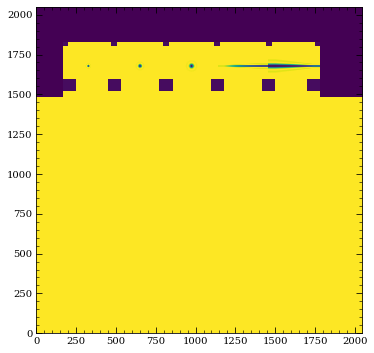

In [14]:
plt.imshow(im_bg)